#### Imports

In [1]:
import requests
import pandas as pd
import pickle
from os import path
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from dataclasses import dataclass
from joblib import Parallel, delayed
pd.set_option('display.max_colwidth', -1)

#### Constants

In [2]:
API = "https://explorer.helium.foundation/api"

#### Helpers

In [3]:
def dashed(name):
    ''' Convert title name to lower dashed name '''
    return "-".join(name.lower().split(" "))

def get_loc_and_city(hotspots, name):
    ''' Get h3 str and city of given hotspot name '''
    h = next(x for x in hotspots if dashed(x['name']) == name)
    return (h['location'], h['long_city'])

def get_witnesses(hname, b58):
    ''' Get witnesses for given hotspot name and b58 addr '''
    r = requests.get("{}/witnesses/{}".format(API, b58))
    assert(r.status_code == 200)
    witnesses = r.json()['data']
    if len(witnesses) > 0:
        witnesses = [dashed(w['name']) for w in witnesses]
    else:
        witnesses = []
    return {"name": dashed(hname), "witnesses": witnesses}

@dataclass
class Node:
    ''' Class to represent a graph node '''
    loc: str
    name: str
    city: str

    # to make this class hashable
    def __eq__(self, other):
        return self.loc == other.loc and self.name == other.name
    def __hash__(self):
        return int(self.loc, 16)

def create_witness_dict(witness_list):
    ''' Create witness dictionary from list of witnesses '''
    witnesses = {}
    for d in witness_list:
        h = d['name']
        ws = d['witnesses']
        (h_loc, h_city) = get_loc_and_city(hotspots, h)
        if h_loc:
            key = Node(name=h, loc=h_loc, city=h_city)
            if len(ws) > 0:
                nodes = []
                for w in ws:
                    (w_loc, w_city) = get_loc_and_city(hotspots, w)
                    node = Node(name=w, loc=w_loc, city=w_city)
                    nodes.append(node)
                witnesses[key] = nodes
            else:
                witnesses[key] = []
    return witnesses

def create_or_fetch_witness_list(witness_list_pickle):
    ''' Check if we already have a pickled object for getting witness list faster '''
    if path.exists(witness_list_pickle):
        with open(witness_list_pickle, 'rb') as handle:
            witness_list = pickle.load(handle)
    else:
        # make the witness fetching marginally faster by parallelizing requests
        witness_list = Parallel(n_jobs=8)(delayed(get_witnesses)(n, a) for (n, a) in [(x['name'], x['address']) for x in hotspots])
        with open(witness_list_pickle, 'wb') as handle:
            pickle.dump(witness_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return witness_list

def create_or_fetch_witness_dict(witness_list, witness_dict_pickle):
    ''' Check if we already have a pickled object for getting witness dict faster '''
    if path.exists(witness_dict_pickle):
        with open(witness_dict_pickle, 'rb') as handle:
            witness_dict = pickle.load(handle)
    else:
        # make the witness fetching marginally faster by parallelizing requests
        witness_dict = create_witness_dict(witness_list)
        with open(witness_dict_pickle, 'wb') as handle:
            pickle.dump(witness_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return witness_dict

def create_or_fetch_graph(graph_pickle):
    ''' Check if we already have a pickled graph '''
    if path.exists(graph_pickle):
        return nx.read_gpickle(graph_pickle)
    else:
        G = nx.Graph()
        G.add_nodes_from(witnesses.keys())
        for k, v in witnesses.items():
            G.add_edges_from([(k, t) for t in v])
        nx.write_gpickle(G, graph_pickle, protocol=pickle.HIGHEST_PROTOCOL)
    return G

#### Hotspots

In [4]:
hr = requests.get("{}/hotspots".format(API))
assert(hr.status_code == 200)
hotspots = hr.json()['data']

#### Witnesses file pickled 3033 hotspots @ height 198410

In [5]:
# check if we have witnesses locally
witness_list = create_or_fetch_witness_list('files/witnesses.pickle')
witnesses = create_or_fetch_witness_dict(witness_list, 'files/witness_dict.pickle')
G = create_or_fetch_graph('files/witness_graph.gpickle')

##### Is the network connected?

In [6]:
nx.is_connected(G)

False

##### What is the cluster average?

In [7]:
nx.algorithms.cluster.average_clustering(G)

0.4062333971727669

#### Some interesting hotspots

In [11]:
name='tall-blonde-condor'
(loc, city) = get_loc_and_city(hotspots, name)
node = Node(name=name, loc=loc, city=city)
print(node)
print(len(nx.node_connected_component(G, node)))
print(list(nx.neighbors(G, node)))

Node(loc='8c2830b81125bff', name='tall-blonde-condor', city='San Rafael')
3
[Node(loc='8c2830b818889ff', name='proud-clay-aardvark', city='San Rafael'), Node(loc='8c2830b842235ff', name='short-sky-panther', city='San Rafael')]


In [12]:
name='lone-violet-orca'
(loc, city) = get_loc_and_city(hotspots, name)
node = Node(name=name, loc=loc, city=city)
print(node)
print(len(nx.node_connected_component(G, node)))
print(list(nx.neighbors(G, node)))

Node(loc='8c2830ba0c9a9ff', name='lone-violet-orca', city='Kentfield')
351
[Node(loc='8c2830ba0c9a9ff', name='spicy-honey-hawk', city='Kentfield'), Node(loc='8c283082b00d9ff', name='zealous-cream-swallow', city='San Francisco'), Node(loc='8c2830ba626d9ff', name='muscular-slate-meerkat', city='Kentfield'), Node(loc='8c2830ba450b5ff', name='rare-burlap-lizard', city='Larkspur')]


In [13]:
name='huge-glossy-robin'
(loc, city) = get_loc_and_city(hotspots, name)
node = Node(name=name, loc=loc, city=city)
print(node)
print(len(nx.node_connected_component(G, node)))
print(list(nx.neighbors(G, node)))

Node(loc='8c283082bc48dff', name='huge-glossy-robin', city='San Francisco')
351
[Node(loc='8c283095c768bff', name='sharp-jetblack-dove', city='San Francisco')]


#### How many total components? For example: a graph with three compents:
<img src="files/3-component-graph.png" style="width:400px">

In [15]:
cc = list(nx.connected_components(G))
scc = sorted(cc, key=len, reverse=True)
print('Total connected components (sub-graphs): {}'.format(len(scc)))

Total connected components (sub-graphs): 1222


In [16]:
print('Top 50 biggest sub graphs: \n{}'.format([len(i) for i in scc[:50]]))

Top 50 biggest sub graphs: 
[351, 286, 154, 111, 94, 82, 62, 55, 35, 33, 31, 27, 26, 22, 22, 20, 20, 20, 17, 14, 13, 12, 12, 10, 10, 10, 10, 10, 9, 7, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]


In [17]:
def draw(scc, rank):
    graph = G.subgraph(scc[rank])
    pos = graphviz_layout(graph)
    print('Rank: {}, Number of hotspots: {}'.format(rank+1, len(nx.nodes(graph))))
    nx.draw(graph, pos, with_labels=False, node_size=10)

##### Top 10 Disconnected sub graphs sorted by number of connected hotspots

Rank: 1, Number of hotspots: 351


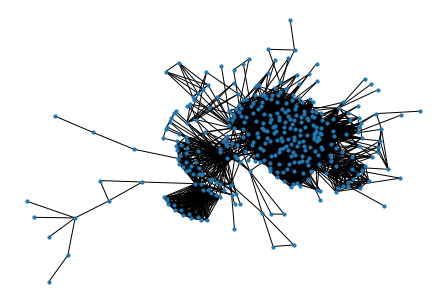

In [18]:
draw(scc, 0)

Rank: 2, Number of hotspots: 286


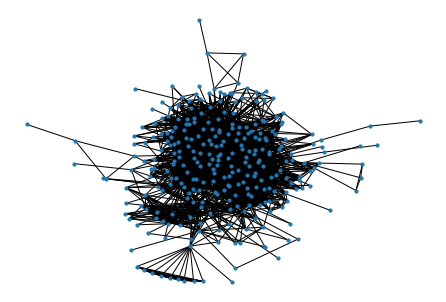

In [19]:
draw(scc, 1)

Rank: 3, Number of hotspots: 154


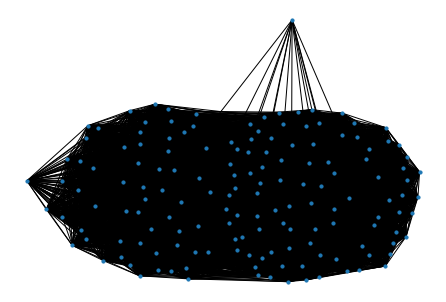

In [20]:
draw(scc, 2)

Rank: 4, Number of hotspots: 111


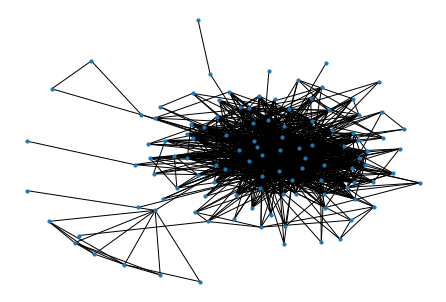

In [21]:
draw(scc, 3)

Rank: 5, Number of hotspots: 94


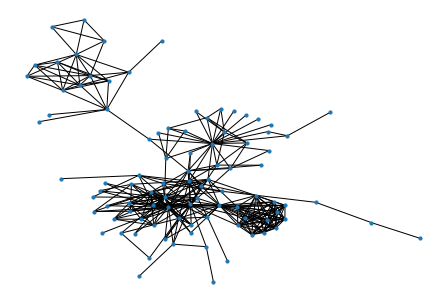

In [22]:
draw(scc, 4)

Rank: 6, Number of hotspots: 82


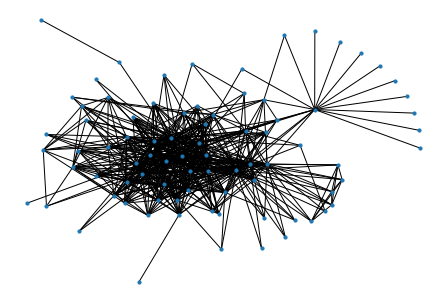

In [23]:
draw(scc, 5)

Rank: 7, Number of hotspots: 62


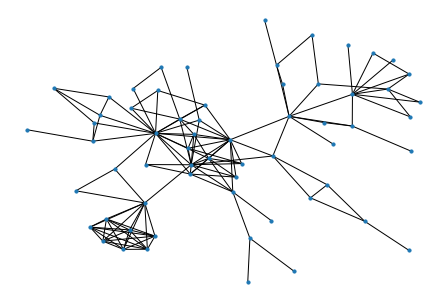

In [24]:
draw(scc, 6)

Rank: 8, Number of hotspots: 55


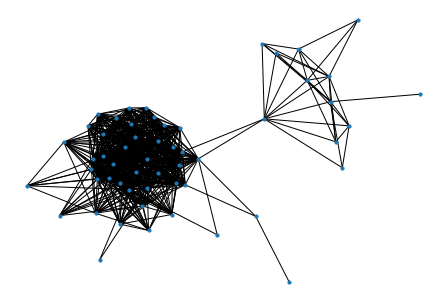

In [25]:
draw(scc, 7)

Rank: 9, Number of hotspots: 35


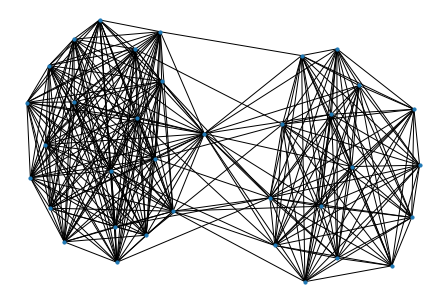

In [26]:
draw(scc, 8)

Rank: 10, Number of hotspots: 33


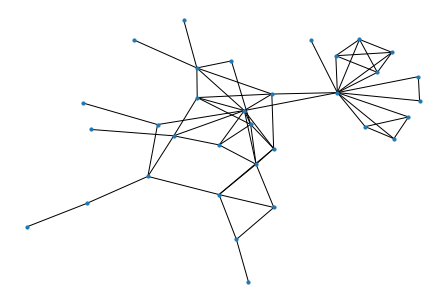

In [27]:
draw(scc, 9)

Rank: 11, Number of hotspots: 31


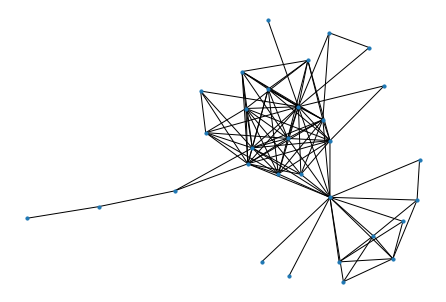

In [28]:
draw(scc, 10)